In [ ]:
!pip install tensorflow==2.10.0

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Flatten, Input, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
!pip install transformers
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
#load dataset
df = pd.read_csv("Final_preprocessed_dataset_portuguese.csv")
#df.fillna('', inplace=True)

In [ ]:
def plot_train_val_loss_acc(history):
    # plot learning curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plot validation curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Split data into train and test sets
X = df['Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

#Tokenize the input texts
#X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
#X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Save tokenized data
#with open('X_train_tokenized_distilBERT_uncased_portuguese.pkl', 'wb') as f:
#  pickle.dump(X_train_tokenized, f)

#with open('X_test_tokenized_distilBERT_uncased_portuguese.pkl', 'wb') as f:
#  pickle.dump(X_test_tokenized, f)

# Load tokenized data
with open('X_train_tokenized_distilBERT_uncased_portuguese.pkl', 'rb') as f:
  X_train_tokenized = pickle.load(f)

with open('X_test_tokenized_distilBERT_uncased_portuguese.pkl', 'rb') as f:
  X_test_tokenized = pickle.load(f)

In [ ]:
# Load the pre-trained DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Unfreeze the DistilBERT layers
distilbert_model.trainable = True

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')

# Pass the input through the pre-trained DistilBERT model
sequence_output = distilbert_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
x = Dropout(0.2)(x)  # Add a dropout layer for regularization

output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Set different learning rates for DistilBERT layers and other layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

Epoch 1/10
791/791 [==============================] - 721s 887ms/step - loss: 0.3152 - accuracy: 0.8541 - val_loss: 0.2313 - val_accuracy: 0.8963
Epoch 2/10
791/791 [==============================] - 700s 885ms/step - loss: 0.1630 - accuracy: 0.9320 - val_loss: 0.2221 - val_accuracy: 0.9143
Epoch 3/10
791/791 [==============================] - 699s 883ms/step - loss: 0.0851 - accuracy: 0.9653 - val_loss: 0.2088 - val_accuracy: 0.9186
Epoch 4/10
791/791 [==============================] - 696s 880ms/step - loss: 0.0402 - accuracy: 0.9864 - val_loss: 0.2360 - val_accuracy: 0.9189
Epoch 5/10
791/791 [==============================] - 697s 881ms/step - loss: 0.0210 - accuracy: 0.9944 - val_loss: 0.2870 - val_accuracy: 0.9209
Epoch 6/10
791/791 [==============================] - 695s 879ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.3023 - val_accuracy: 0.9138
Epoch 7/10
791/791 [==============================] - 693s 877ms/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 0.3297 -

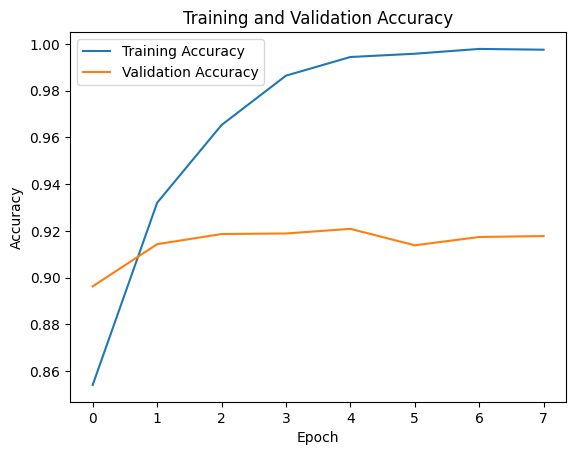

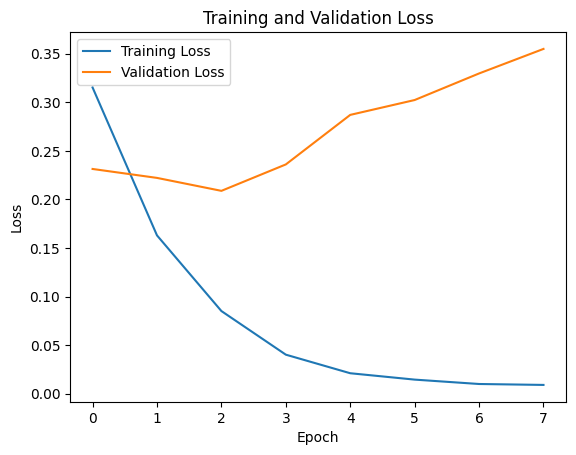

In [ ]:
plot_train_val_loss_acc(history)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

198/198 [==============================] - 55s 276ms/step - loss: 0.2870 - accuracy: 0.9209
Test loss: 0.287, Test accuracy: 0.921


396/396 [==============================] - 58s 141ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      6285
           1       0.93      0.91      0.92      6363

    accuracy                           0.92     12648
   macro avg       0.92      0.92      0.92     12648
weighted avg       0.92      0.92      0.92     12648



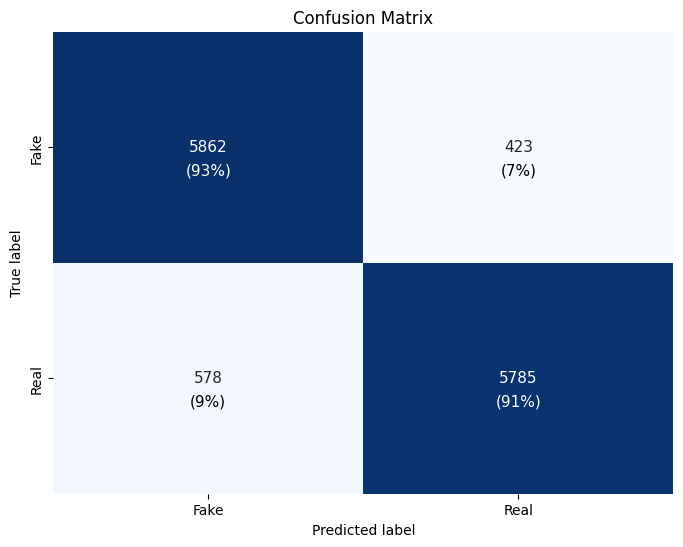

In [ ]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

# Compute normalized values
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'], annot_kws={"fontsize": 11})

# Add normalized values below the actual values
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        text_color = 'black' if conf_mat_norm[i, j] < 0.5 else 'white'
        ax.text(j + 0.5, i + 0.6, f'({conf_mat_norm[i, j]:.0%})', ha='center', va='center', color=text_color, fontsize=11)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('dir_model_DistilBERT_92_portuguese')

In [ ]:
# Define the custom objects
custom_objects = {
    'TFDistilBertModel': TFDistilBertModel,
}

# Load the model with custom objects
model = load_model('dir_model_DistilBERT_92_portuguese', custom_objects=custom_objects)

In [ ]:
# Preprocess the text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 128  # Max sequence length used during training
text = 'Médicos e farmacêuticos dizem que está a aumentar o risco de se morrer de uma doença que não a covid-19 Especialistas alertam que as medidas extraordinárias de confinamento produzem efeitos mais gravosos para a sociedade do que a pandemia. Numa carta aberta, médicos e farmacêuticos manifestaram-se contra a tomada de medidas extraordinárias de confinamento para combater a pandemia. Os profissionais da saúde alertam que estas medidas produzem efeitos mais gravosos para a sociedade do que a própria covid-19. Os especialistas defendem que a pandemia continue a ser prioritária, mas com outras medidas de combate. Pedem medidas adequadas, como a aceleração da vacinação, simplificando o processo, e apelam também para que se envolvam agentes da sociedade civil, como por exemplo as farmácias, de forma a aumentar rapidamente a cobertura vacinal. Médicos e farmacêuticos defendem também o aperfeiçoamento da vigilância epidemiológica, que consideram estar a ser um insucesso no país. Sublinham ainda que, nos últimos 14 dias, a taxa de mortalidade pelo SARS-Cov-2 foi de 0,03 por 100 mil habitantes contra uma taxa de mortalidade por outras doenças e causas de morte de 2,7 por 100 mil.'
text_tokens = tokenizer.encode_plus(text, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf')

# Make the prediction
prediction = model.predict(text_tokens['input_ids'])[0][0]

# Convert prediction to a label
label = 1 if prediction >= 0.5 else 0
confidence = prediction if prediction >= 0.5 else 1 - prediction

print(f"Prediction: {label}")
print(f"Confidence: {confidence:.4f}")

1/1 [==============================] - 2s 2s/step
Prediction: 1
Confidence: 0.7771
